# Table of Contents

* [Setting up the Environment](#section1)
* [Creating Input](#section2)
* [Model Creation](#section3)
* [Checking Topic Coherence](#section4)
* [Explore Model](#section5)
    * [Printing Topics](#section5_1)
    * [Looking for Topic Evolution](#section5_2)
    * [Visualising Dynamic Topic Models](#section5_3)

# Setting up the Environment <a class=anchor id=section1></a>

In [2]:
%%capture
!apt-get update
!apt-get install --reinstall build-essential -y
!pip install spacy
!pip install git+https://github.com/RaRe-Technologies/gensim.git@refs/pull/3172/head
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

In [3]:
import re
import spacy
import pickle
import gensim
import logging
import warnings
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from pprint import pprint
from datetime import datetime
from nltk.corpus import stopwords
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader
from gensim.parsing.preprocessing import preprocess_string


%matplotlib inline
pyLDAvis.enable_notebook()
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

# Creating Input <a class=anchor id=section2></a>

In [4]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [5]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [6]:
# Setence to Words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
corpus_topics = ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979', 'TRANSFORMED/1980-1989', 
                 'TRANSFORMED/1990-1999', 'TRANSFORMED/2000-2009', 'TRANSFORMED/2010-2019']

In [8]:
flag=True

for corpus_root in corpus_topics:
    rows = []
    corpus = PlaintextCorpusReader(corpus_root, '.*txt')
    text_list = corpus.fileids()
    for text in text_list:
        if corpus_root in ['TRANSFORMED/1950-1959', 'TRANSFORMED/1960-1969', 'TRANSFORMED/1970-1979']:
            identifier = text.split("_")[0]
        else:
            identifier = text.split("_")[-1][:-4]
        rows.append([identifier, " ".join(corpus.words(text))])
    # CREATE DATFRAME
    df = pd.DataFrame.from_records(rows, columns=['id', 'content'])
    
    # CLEANING
    # Convert to list
    data = df['content'].values.tolist()
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Sentence to words
    data_words = list(sent_to_words(data))
    
    # BUILD THE BIGRAM AND TRIGRAM MODELS
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    # Faster way to get a sentence clubbed as a bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # INPUT FOR CREATING THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
    if not flag:
        texts.extend(data_lemmatized)
    else:
        texts = data_lemmatized
        flag = False
        
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print("*"*20+"FINISHED"+"*"*20)

********************FINISHED********************


In [9]:
with open('news_texts.pkl', 'wb') as f:
    pickle.dump(texts, f)
with open('news_corpus.pkl', 'wb') as f:
    pickle.dump(corpus, f)
with open('news_dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

# Model Creation <a class=anchor id=section3></a>

In [10]:
print("Started loading..")
with open('news_corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
with open('news_dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)
print("Finished loading..")

Started loading..
Finished loading..


In [ ]:
# parameters
name = "twenty"
num_topics = 20

In [ ]:
# create model
print("Started training..")
start = datetime.now()
time_slice = [1051, 2900, 1258, 1771, 1520, 2010, 2852, 412]
lda_seq = LdaSeqModel(corpus=corpus, time_slice=time_slice, id2word=dictionary,
                      num_topics=num_topics, chunksize=3000, passes=3)
print("Finished training..")
end = datetime.now()
time_taken = end-start

In [ ]:
!mkdir 'LDA Seq Models'

In [ ]:
# save
print("Saving model..")
with open(name+'.pkl', 'wb') as f:
    pickle.dump(lda_seq, f)
print("Saved model!")
with open('LDA Seq Models/'+name+".txt", "w") as text_file:
    print(f"Time Taken: {time_taken}", file=text_file)

# Checking Topic Coherence <a class=anchor id=section4></a>

In [4]:
# use ml.c5.4xlarge for this section
models = {'two': None, 'three': None, 'four': None, 'five': None, 'six': None, 'seven': None, 'eight': None,
          'nine': None, 'ten': None, 'eleven': None, 'twelve': None, 'thirteen': None, 'fourteen': None,
          'fifteen': None, 'sixteen': None, 'seventeen': None, 'eighteen': None, 'nineteen': None, 'twenty': None}

In [5]:
print("Started loading..")
with open('news_corpus.pkl', 'rb') as f:
    corpus = pickle.load(f)
with open('news_texts.pkl', 'rb') as f:
    texts = pickle.load(f)
with open('news_dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)
for model_name, model in models.items():
    print("Loading model {}".format(model_name))
    with open('LDA Seq Models/'+model_name+'.pkl', 'rb') as f:
        models[model_name] = pickle.load(f)
print("Finished loading..")

Started loading..
Loading model two
Loading model three
Loading model four
Loading model five
Loading model six
Loading model seven
Loading model eight
Loading model nine
Loading model ten
Loading model eleven
Loading model twelve
Loading model thirteen
Loading model fourteen
Loading model fifteen
Loading model sixteen
Loading model seventeen
Loading model eighteen
Loading model nineteen
Loading model twenty
Finished loading..


In [8]:
def calculate_score(m, metric):
    metric_scores = []
    for time in range(0, 7):
        topics_dtm = m.dtm_coherence(time=time)
        if metric == "umass":
            coherence_model = CoherenceModel(topics=topics_dtm, corpus=corpus, dictionary=dictionary,
                                             coherence='u_mass')
        else:
            coherence_model = CoherenceModel(topics=topics_dtm, texts=texts, dictionary=dictionary, coherence='c_npmi')
        metric_scores.append(coherence_model.get_coherence())
    return metric_scores

In [9]:
scores = []
metric_name = "npmi"
for model_name, model in models.items():
    print("Calculating scores for model {}".format(model_name))
    scores.append(calculate_score(model, metric_name))
scores = list(map(list, zip(*scores)))
print("*"*20+"FINISHED"+"*"*20)

Calculating scores for model two
Calculating scores for model three
Calculating scores for model four
Calculating scores for model five
Calculating scores for model six
Calculating scores for model seven
Calculating scores for model eight
Calculating scores for model nine
Calculating scores for model ten
Calculating scores for model eleven
Calculating scores for model twelve
Calculating scores for model thirteen
Calculating scores for model fourteen
Calculating scores for model fifteen
Calculating scores for model sixteen
Calculating scores for model seventeen
Calculating scores for model eighteen
Calculating scores for model nineteen
Calculating scores for model twenty


In [10]:
# save
with open('scores_'+metric_name+'.pkl', 'wb') as fp:
    pickle.dump(scores, fp)
print("Saved scores")

Saved scores


In [11]:
# load
with open('scores_'+metric_name+'.pkl', 'rb') as f:
    scores = pickle.load(f)

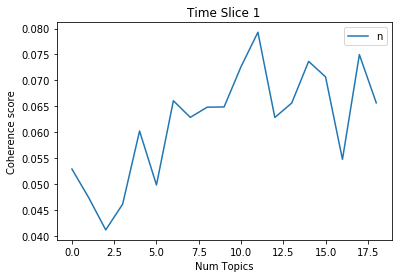

A maximum npmi score of 0.07928972270396326 was achieved at K=13
Number of topics = 2  has NPMI coherence Value of 0.0529
Number of topics = 3  has NPMI coherence Value of 0.0473
Number of topics = 4  has NPMI coherence Value of 0.0412
Number of topics = 5  has NPMI coherence Value of 0.0461
Number of topics = 6  has NPMI coherence Value of 0.0602
Number of topics = 7  has NPMI coherence Value of 0.0498
Number of topics = 8  has NPMI coherence Value of 0.0661
Number of topics = 9  has NPMI coherence Value of 0.0629
Number of topics = 10  has NPMI coherence Value of 0.0648
Number of topics = 11  has NPMI coherence Value of 0.0649
Number of topics = 12  has NPMI coherence Value of 0.0726
Number of topics = 13  has NPMI coherence Value of 0.0793
Number of topics = 14  has NPMI coherence Value of 0.0629
Number of topics = 15  has NPMI coherence Value of 0.0656
Number of topics = 16  has NPMI coherence Value of 0.0737
Number of topics = 17  has NPMI coherence Value of 0.0707
Number of topic

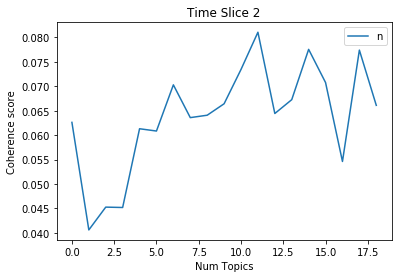

A maximum npmi score of 0.08105630261748052 was achieved at K=13
Number of topics = 2  has NPMI coherence Value of 0.0626
Number of topics = 3  has NPMI coherence Value of 0.0406
Number of topics = 4  has NPMI coherence Value of 0.0453
Number of topics = 5  has NPMI coherence Value of 0.0452
Number of topics = 6  has NPMI coherence Value of 0.0613
Number of topics = 7  has NPMI coherence Value of 0.0608
Number of topics = 8  has NPMI coherence Value of 0.0703
Number of topics = 9  has NPMI coherence Value of 0.0636
Number of topics = 10  has NPMI coherence Value of 0.0641
Number of topics = 11  has NPMI coherence Value of 0.0664
Number of topics = 12  has NPMI coherence Value of 0.0734
Number of topics = 13  has NPMI coherence Value of 0.0811
Number of topics = 14  has NPMI coherence Value of 0.0644
Number of topics = 15  has NPMI coherence Value of 0.0673
Number of topics = 16  has NPMI coherence Value of 0.0776
Number of topics = 17  has NPMI coherence Value of 0.0708
Number of topic

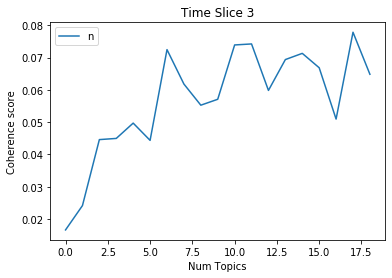

A maximum npmi score of 0.07785420330972415 was achieved at K=19
Number of topics = 2  has NPMI coherence Value of 0.0166
Number of topics = 3  has NPMI coherence Value of 0.0242
Number of topics = 4  has NPMI coherence Value of 0.0446
Number of topics = 5  has NPMI coherence Value of 0.045
Number of topics = 6  has NPMI coherence Value of 0.0497
Number of topics = 7  has NPMI coherence Value of 0.0444
Number of topics = 8  has NPMI coherence Value of 0.0725
Number of topics = 9  has NPMI coherence Value of 0.0618
Number of topics = 10  has NPMI coherence Value of 0.0553
Number of topics = 11  has NPMI coherence Value of 0.0571
Number of topics = 12  has NPMI coherence Value of 0.0739
Number of topics = 13  has NPMI coherence Value of 0.0742
Number of topics = 14  has NPMI coherence Value of 0.0598
Number of topics = 15  has NPMI coherence Value of 0.0694
Number of topics = 16  has NPMI coherence Value of 0.0713
Number of topics = 17  has NPMI coherence Value of 0.0669
Number of topics

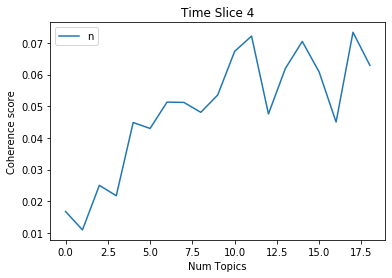

A maximum npmi score of 0.0733824898208208 was achieved at K=19
Number of topics = 2  has NPMI coherence Value of 0.0168
Number of topics = 3  has NPMI coherence Value of 0.0109
Number of topics = 4  has NPMI coherence Value of 0.025
Number of topics = 5  has NPMI coherence Value of 0.0217
Number of topics = 6  has NPMI coherence Value of 0.0449
Number of topics = 7  has NPMI coherence Value of 0.043
Number of topics = 8  has NPMI coherence Value of 0.0513
Number of topics = 9  has NPMI coherence Value of 0.0512
Number of topics = 10  has NPMI coherence Value of 0.0481
Number of topics = 11  has NPMI coherence Value of 0.0536
Number of topics = 12  has NPMI coherence Value of 0.0673
Number of topics = 13  has NPMI coherence Value of 0.0722
Number of topics = 14  has NPMI coherence Value of 0.0476
Number of topics = 15  has NPMI coherence Value of 0.0619
Number of topics = 16  has NPMI coherence Value of 0.0705
Number of topics = 17  has NPMI coherence Value of 0.0608
Number of topics =

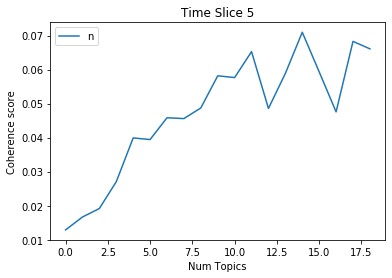

A maximum npmi score of 0.07096819398537314 was achieved at K=16
Number of topics = 2  has NPMI coherence Value of 0.0129
Number of topics = 3  has NPMI coherence Value of 0.0167
Number of topics = 4  has NPMI coherence Value of 0.0192
Number of topics = 5  has NPMI coherence Value of 0.027
Number of topics = 6  has NPMI coherence Value of 0.0399
Number of topics = 7  has NPMI coherence Value of 0.0394
Number of topics = 8  has NPMI coherence Value of 0.0458
Number of topics = 9  has NPMI coherence Value of 0.0456
Number of topics = 10  has NPMI coherence Value of 0.0487
Number of topics = 11  has NPMI coherence Value of 0.0582
Number of topics = 12  has NPMI coherence Value of 0.0577
Number of topics = 13  has NPMI coherence Value of 0.0653
Number of topics = 14  has NPMI coherence Value of 0.0486
Number of topics = 15  has NPMI coherence Value of 0.0589
Number of topics = 16  has NPMI coherence Value of 0.071
Number of topics = 17  has NPMI coherence Value of 0.0593
Number of topics 

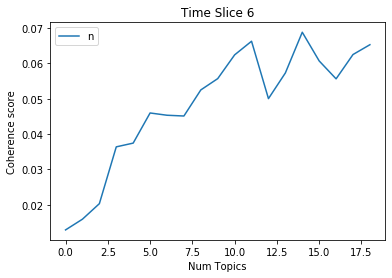

A maximum npmi score of 0.06881693368138758 was achieved at K=16
Number of topics = 2  has NPMI coherence Value of 0.0129
Number of topics = 3  has NPMI coherence Value of 0.0159
Number of topics = 4  has NPMI coherence Value of 0.0203
Number of topics = 5  has NPMI coherence Value of 0.0364
Number of topics = 6  has NPMI coherence Value of 0.0374
Number of topics = 7  has NPMI coherence Value of 0.046
Number of topics = 8  has NPMI coherence Value of 0.0453
Number of topics = 9  has NPMI coherence Value of 0.0451
Number of topics = 10  has NPMI coherence Value of 0.0525
Number of topics = 11  has NPMI coherence Value of 0.0557
Number of topics = 12  has NPMI coherence Value of 0.0624
Number of topics = 13  has NPMI coherence Value of 0.0663
Number of topics = 14  has NPMI coherence Value of 0.05
Number of topics = 15  has NPMI coherence Value of 0.0573
Number of topics = 16  has NPMI coherence Value of 0.0688
Number of topics = 17  has NPMI coherence Value of 0.0607
Number of topics =

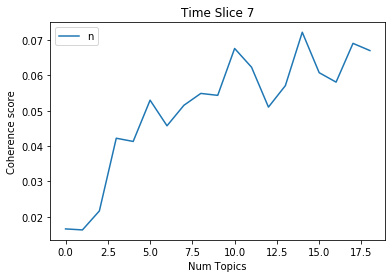

A maximum npmi score of 0.072219209688506 was achieved at K=16
Number of topics = 2  has NPMI coherence Value of 0.0165
Number of topics = 3  has NPMI coherence Value of 0.0163
Number of topics = 4  has NPMI coherence Value of 0.0216
Number of topics = 5  has NPMI coherence Value of 0.0422
Number of topics = 6  has NPMI coherence Value of 0.0413
Number of topics = 7  has NPMI coherence Value of 0.053
Number of topics = 8  has NPMI coherence Value of 0.0457
Number of topics = 9  has NPMI coherence Value of 0.0515
Number of topics = 10  has NPMI coherence Value of 0.0549
Number of topics = 11  has NPMI coherence Value of 0.0544
Number of topics = 12  has NPMI coherence Value of 0.0676
Number of topics = 13  has NPMI coherence Value of 0.0623
Number of topics = 14  has NPMI coherence Value of 0.051
Number of topics = 15  has NPMI coherence Value of 0.0571
Number of topics = 16  has NPMI coherence Value of 0.0722
Number of topics = 17  has NPMI coherence Value of 0.0608
Number of topics = 

In [17]:
# Show graph
for i in range(0, len(scores)):
    score = scores[i]
    x = range(0, len(score))
    plt.plot(x, score)
    plt.title("Time Slice "+str(i+1))
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend((metric_name), loc='best')
    plt.show()
    # Print the coherence scores
    maximum = max(score)
    indices = [i for i, v in enumerate(score) if v == maximum]
    print("A maximum {} score of {} was achieved at K={}".format(metric_name, maximum, indices[0]+2))

    for m, cv in zip(x, score):
        print("Number of topics =", m+2, " has NPMI coherence Value of", round(cv, 4))

> We get the results as follows:<br>
Time slice 1 has the best NPMI score when number of topics is 13<br>
Time slice 2 has the best NPMI score when number of topics is 13<br>
Time slice 3 has the best NPMI score when number of topics is 19<br>
Time slice 4 has the best NPMI score when number of topics is 19<br>
Time slice 5 has the best NPMI score when number of topics is 16<br>
Time slice 6 has the best NPMI score when number of topics is 16<br>
Time slice 7 has the best NPMI score when number of topics is 16<br><br>
This means that:<br>
Two time-slices found 13 topics as the best.<br>
Two time-slices found 19 topics as the best.<br>
Three time-slices found 16 topics as the best.<br><br>
Looking at the above result, and the actual scores for each time slice, we proceed with using 16 as the ideal number of topics.

## Explore Model <a class=anchor id=section5></a>

In [19]:
# load the correct model
ldaseq = models["sixteen"]

## Printing Topics <a class=anchor id=section5_1></a>

To print all topics from a particular time-period, simply use `print_topics`. The input parameter to print_topics is a time-slice option. By passing 0 we are seeing the topics in the 1st time-slice. The result would be a list of lists, where each individual list contains a tuple of the most probable words in the topic. i.e (word, word_probability)

In [20]:
# 20 topcis per time slice. Each topic is made up of keywords.
ldaseq.print_topics(time=0)

[[('company', 0.05518109289148827),
  ('share', 0.04373915580898176),
  ('sale', 0.040142418630967784),
  ('income', 0.02790743675107574),
  ('yesterday', 0.020310503418426603),
  ('earn', 0.01898001937181926),
  ('report', 0.018967437412096028),
  ('earning', 0.01676578550927192),
  ('cent', 0.01604510394456807),
  ('permission', 0.015315693944515393),
  ('quarter', 0.013211837689951645),
  ('profit', 0.011907720899224187),
  ('month', 0.011906632141563709),
  ('increase', 0.011478949043364352),
  ('stock', 0.00910559659147439),
  ('period', 0.009050511258254061),
  ('revenue', 0.008469058529865141),
  ('corporation', 0.00828043439892739),
  ('first', 0.00798952792157378),
  ('record', 0.007968380569103768)],
 [('ship', 0.027154826938532557),
  ('cargo', 0.020361623365755956),
  ('vessel', 0.013614134544858221),
  ('plane', 0.013444949100239887),
  ('container', 0.01255546066156087),
  ('shipping', 0.012140232938515712),
  ('flight', 0.01064260617390795),
  ('airline', 0.0102871836167

## Looking for Topic Evolution <a class=anchor id=section5_2></a>

To fix a topic and see it evolve, use `print_topic_times`. The input parameter is the topic_id In this case, we are looking at the evolution of the technology topic.

In [21]:
ldaseq.print_topic_times(topic=0) # evolution of 1st topic

[[('company', 0.05518109289148827),
  ('share', 0.04373915580898176),
  ('sale', 0.040142418630967784),
  ('income', 0.02790743675107574),
  ('yesterday', 0.020310503418426603),
  ('earn', 0.01898001937181926),
  ('report', 0.018967437412096028),
  ('earning', 0.01676578550927192),
  ('cent', 0.01604510394456807),
  ('permission', 0.015315693944515393),
  ('quarter', 0.013211837689951645),
  ('profit', 0.011907720899224187),
  ('month', 0.011906632141563709),
  ('increase', 0.011478949043364352),
  ('stock', 0.00910559659147439),
  ('period', 0.009050511258254061),
  ('revenue', 0.008469058529865141),
  ('corporation', 0.00828043439892739),
  ('first', 0.00798952792157378),
  ('record', 0.007968380569103768)],
 [('income', 0.04604850300200023),
  ('sale', 0.04467312644296343),
  ('share', 0.04452677220667896),
  ('company', 0.04424554653969939),
  ('earn', 0.03934552464778781),
  ('earning', 0.017514800244796968),
  ('report', 0.01687109464309964),
  ('yesterday', 0.016075745214678756)

## Visualising Dynamic Topic Models <a class=anchor id=section5_3></a>

In [22]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [23]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=1, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [24]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=2, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [25]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=3, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [26]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=4, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [27]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=5, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

In [28]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=6, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)